In [1]:
# Install Necessary Libraries
!pip install tensorflow[and-cuda] pandas numpy matplotlib seaborn pillow scipy scikit-learn --break-system-packages

In [18]:
# Import Required Libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import random
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from PIL import Image


In [19]:
# Check if TensorFlow is using the GPU
!nvidia-smi
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Sat Sep  7 16:26:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 4000 Ada Gene...    On  | 00000000:C1:00.0 Off |                  Off |
| 30%   31C    P8              14W / 130W |  19953MiB / 20475MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [20]:
# Example Data Generator for Training and Validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Adjust target_size to match your image dimensions
train_generator = train_datagen.flow_from_directory(
    'Micro_Expressions/train/',
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' for multiclass classification
)

validation_generator = validation_datagen.flow_from_directory(
    'Micro_Expressions/test/',
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)


Found 6938 images belonging to 7 classes.
Found 1700 images belonging to 7 classes.


In [27]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),  # Adjust input shape to (48, 48, 3)
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # Assuming you have 7 classes
])


In [28]:
# Define callbacks
# Save the model after every epoch if it is the best seen so far
checkpoint = ModelCheckpoint(
    'models/r1_best_model.keras',        # File path to save the best model
    monitor='val_loss',        # Monitors the validation loss
    save_best_only=True,       # Saves only the best model
    mode='min',                # Mode is 'min' because lower validation loss is better
    verbose=1                  # Verbosity mode
)

# Reduce learning rate when a metric has stopped improving
lr_adjustment = ReduceLROnPlateau(
    monitor='val_loss',    # Monitors the validation loss
    factor=0.5,            # Factor by which the learning rate will be reduced
    patience=3,            # Number of epochs with no improvement before reducing learning rate
    min_lr=1e-6,           # Minimum learning rate
    verbose=1              # Verbosity mode
)

# Stop training when a monitored metric has stopped improving
early_stop = EarlyStopping(
    monitor='val_loss',    # Monitors the validation loss
    patience=5,            # Number of epochs with no improvement before stopping training
    verbose=1,             # Verbosity mode
    restore_best_weights=True  # Restores model weights from the epoch with the best value
)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,855 (4.36 MB)

 Trainable params: 1,142,855 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the Model with Callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[checkpoint, lr_adjustment, early_stop]
)


Epoch 1/30
210/217 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7167 - loss: 0.7886
Epoch 1: val_loss did not improve from 0.81569
217/217 ━━━━━━━━━━━━━━━━━━━━ 29s 127ms/step - accuracy: 0.7168 - loss: 0.7885 - val_accuracy: 0.7388 - val_loss: 0.8161 - learning_rate: 5.0000e-04
Epoch 2/30
210/217 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7184 - loss: 0.7947
Epoch 2: val_loss did not improve from 0.81569
217/217 ━━━━━━━━━━━━━━━━━━━━ 30s 132ms/step - accuracy: 0.7186 - loss: 0.7942 - val_accuracy: 0.7376 - val_loss: 0.8256 - learning_rate: 5.0000e-04
Epoch 3/30
210/217 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7248 - loss: 0.7639
Epoch 3: val_loss improved from 0.81569 to 0.81437, saving model to best_model.keras
217/217 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - accuracy: 0.7246 - loss: 0.7642 - val_accuracy: 0.7335 - val_loss: 0.8144 - learning_rate: 5.0000e-04
Epoch 4/30
210/217 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7258 - loss: 0.7690
Epoch 4: val_loss did not

In [32]:
# model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,428,567 (13.08 MB)

 Trainable params: 1,142,855 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,285,712 (8.72 MB)

In [33]:
# classification report

# Generate true labels and predictions for the validation set
y_true = []
y_pred = []

# Compute predictions for each batch in the validation set
for _ in range(validation_steps):
    x_batch, y_batch = next(validation_generator)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(model.predict(x_batch), axis=1))

# Print the classification report
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

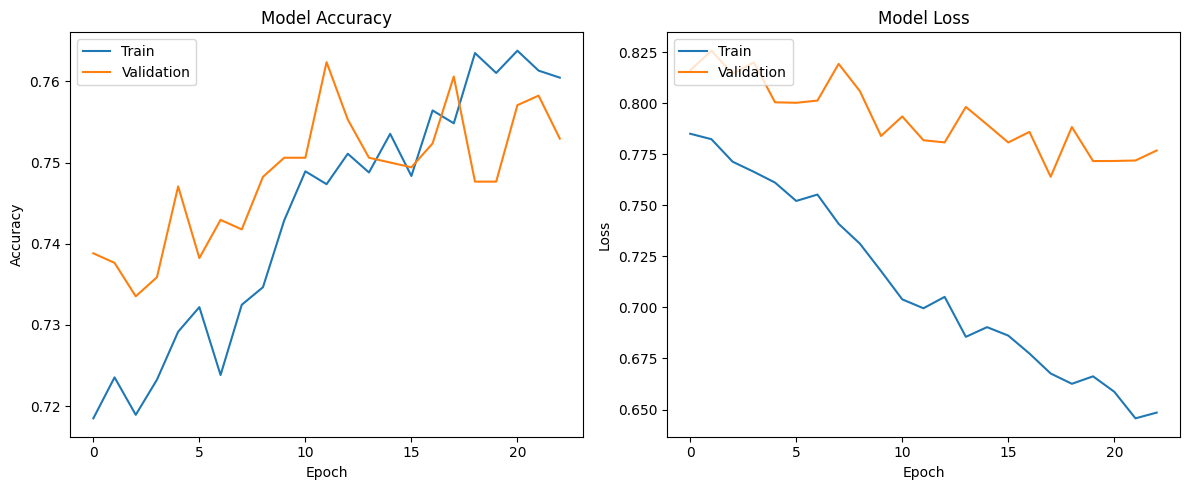

In [34]:
# plot training history
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

<Figure size 800x600 with 0 Axes>

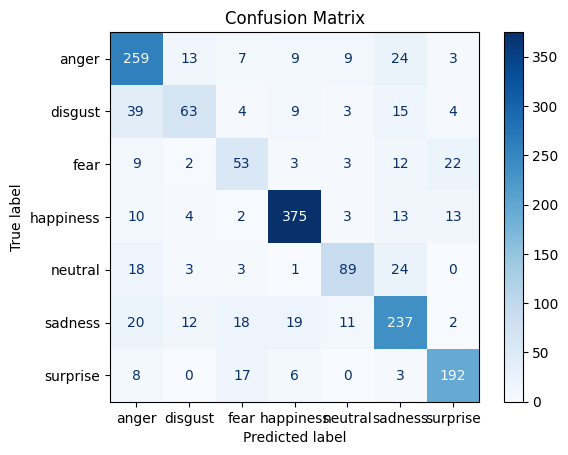

In [35]:
# confusion matrix

# Get the true labels and predictions for the validation set
validation_steps = validation_generator.samples // validation_generator.batch_size
y_true = []
y_pred = []

for _ in range(validation_steps):
    x_batch, y_batch = next(validation_generator)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(model.predict(x_batch), axis=1))

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


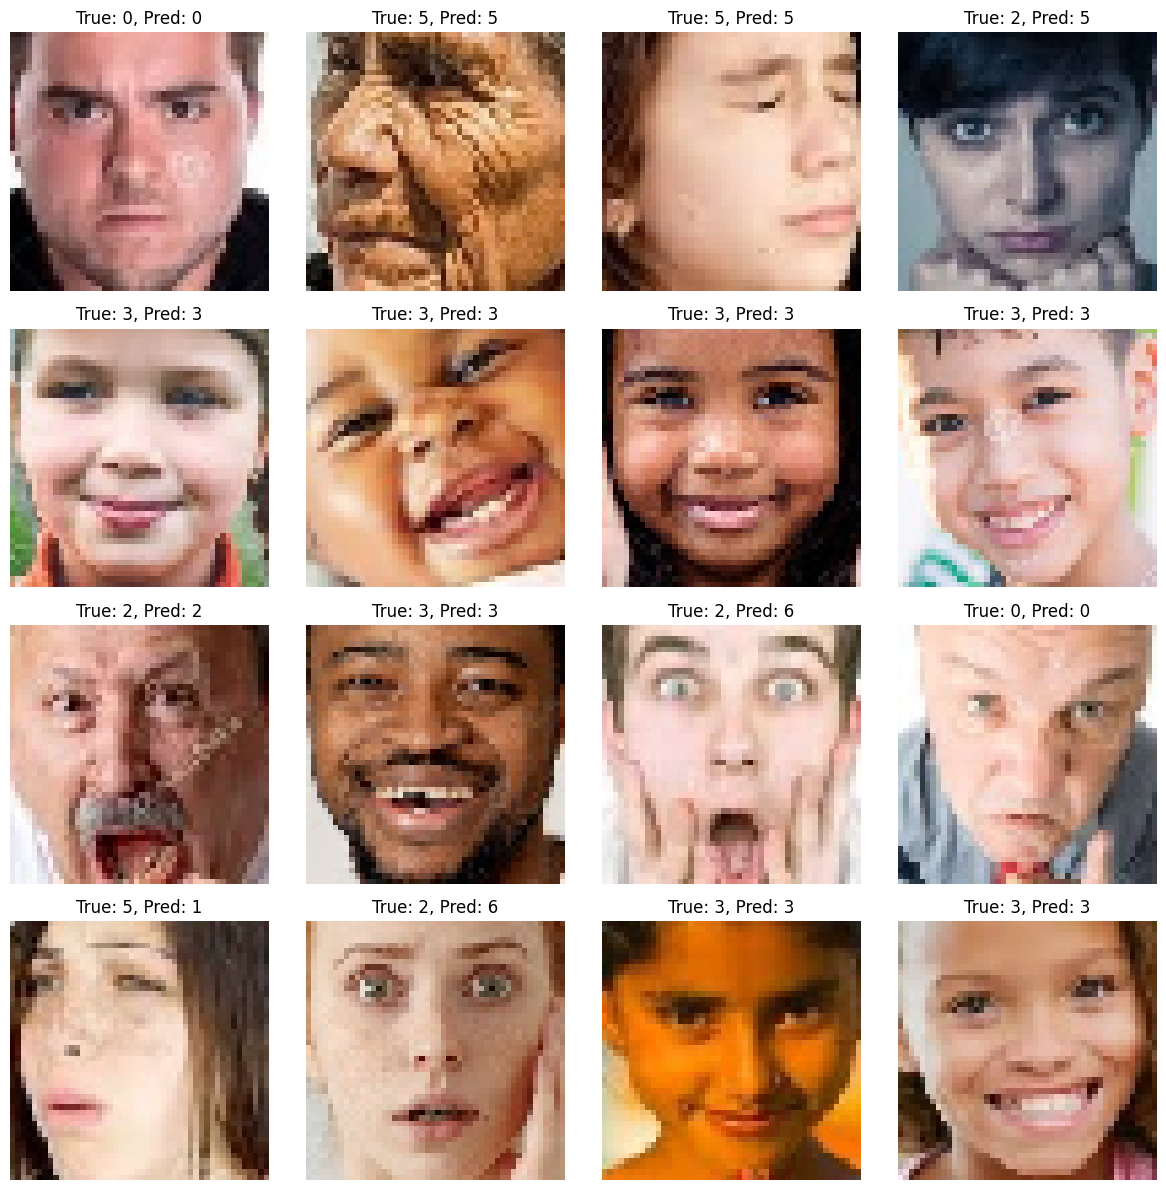

In [36]:
# test model

# Generate a batch of images and labels from the validation generator
x_batch, y_batch = next(validation_generator)

# Select 16 random indices from the batch
random_indices = random.sample(range(len(x_batch)), 16)

# Plot 16 random images with their predicted and true labels
plt.figure(figsize=(12, 12))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(4, 4, i + 1)
    img = x_batch[idx]
    true_label = np.argmax(y_batch[idx])
    prediction = model.predict(img[np.newaxis, ...])
    predicted_label = np.argmax(prediction)

    plt.imshow(img)
    plt.title(f'True: {true_label}, Pred: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [37]:
# Save the Model
model.save('models/r1_expression_classification_model.keras')
print("saved done")